In [3]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive  -o nonempty

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential,Model
from keras import layers
from keras.layers import LSTM,Dense,Dropout,BatchNormalization,Input,Concatenate
from keras.optimizers import RMSprop,Adam
from keras.callbacks import ReduceLROnPlateau

from keras import regularizers 
#from keras.layers.normalization import BatchNormalization

%matplotlib inline

In [7]:
# load the data
dat=pd.read_table('./drive/dat4nn.txt',header=None,delim_whitespace=True)
dat=np.array(dat)
dat

array([[ 0.49237545, -1.31158826,  1.50796416, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.63266203, -1.2111115 ,  1.48764176, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.71568878, -1.19101615,  1.45715816, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.48676759,  0.73813757, -0.28548783, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47130744,  0.59747011, -0.24992363, ...,  0.        ,
         1.        ,  0.        ],
       [-0.45928288,  0.05489563, -0.20927882, ...,  0.        ,
         1.        ,  0.        ]])

In [0]:
# Generate yielding timeseries samples and their targets (similar with codes from Deep Learning with Python)

def generator(data,lookback,delay,min_index,max_index,
                     shuffle=False,batch_size=128,step=6):
    # data: original array, first col indicates response variable
    # lookback: how many timesteps back the input data shold be
    # delay: how many timesteps in the future the target should be
    # min_index, max_index: indicate the beginning and end of timesteps to draw from
    # shuffle: whether to shuffle the data or sample in chronological order
    # batch_size: size of samples per batch
    # step: the period, in timesteps, at which we sample data (mainly for shrinking data size)
    
    if max_index is None:
        max_index=len(data)-delay-1
    i=min_index+lookback
    while 1:
        if shuffle:
            rows=np.random.randint(min_index+lookback,max_index,size=batch_size)
        else:
            if i+batch_size>=max_index:
                i=min_index+lookback
            rows=np.arange(i,min(i+batch_size,max_index))
            i+=len(rows)
            
        samples=np.zeros((len(rows),lookback//step,data.shape[-1]))
        targets=np.zeros((len(rows),delay))
        
        for j,row in enumerate(rows):
            indices_spl=np.arange(rows[j]-lookback,rows[j],step,dtype=np.int64)
            samples[j]=data[indices_spl]
            indices_tgt=np.arange(rows[j],rows[j]+delay,dtype=np.int64)
            targets[j]=data[indices_tgt][1]
        yield samples, targets

In [0]:
# plot
def plt_loss(history):
  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs=range(1,len(loss)+1)

  plt.figure()

  plt.plot(epochs,loss,'r--',label='Training Loss')
  plt.plot(epochs,val_loss,'b',label='Validation Loss')
  plt.title("Training and Validation Loss")
  plt.legend()

  plt.show()

In [0]:
# some global parameters
lookback=24*14
step=3
delay=24
batch_size=128
train_ind=1e4
val_ind=10800
test_ind=None
regularizer=0.00005

In [0]:
# train, val, test data genration
train_gen=generator(dat,lookback=lookback,delay=delay,
                    min_index=0,max_index=train_ind,shuffle=True,step=step,batch_size=batch_size)
val_gen=generator(dat,lookback=lookback,delay=delay,
                    min_index=train_ind+1,max_index=val_ind,shuffle=False,step=step,batch_size=batch_size)
test_gen=generator(dat,lookback=lookback,delay=delay,
                    min_index=val_ind+1,max_index=test_ind,shuffle=False,step=step,batch_size=batch_size)

val_step=val_ind-train_ind-1-lookback
test_step=len(dat)-val_ind-1-lookback

# GRU Based Baseline

In [14]:
# model pipline
model=Sequential()
model.add(layers.GRU(32,input_shape=(None,dat.shape[-1])))
model.add(layers.Dense(24))

model.compile(optimizer=RMSprop(lr=1e-3),loss='mae')
history=model.fit_generator(train_gen,steps_per_epoch=200,epochs=20,validation_data=val_gen,validation_steps=val_step)

Epoch 1/20
200/200 [==============================] - 63s 317ms/step - loss: 0.7209 - val_loss: 0.5430
Epoch 2/20
200/200 [==============================] - 63s 317ms/step - loss: 0.4866 - val_loss: 0.4310
Epoch 3/20
150/200 [=====================>........] - ETA: 9s - loss: 0.3875

200/200 [==============================] - 63s 316ms/step - loss: 0.3767 - val_loss: 0.3501
Epoch 4/20
200/200 [==============================] - 64s 318ms/step - loss: 0.3213 - val_loss: 0.3235
Epoch 5/20
200/200 [==============================] - 63s 316ms/step - loss: 0.2996 - val_loss: 0.3090
Epoch 6/20
 10/200 [>.............................] - ETA: 37s - loss: 0.2848

200/200 [==============================] - 63s 317ms/step - loss: 0.2925 - val_loss: 0.3042
Epoch 7/20
200/200 [==============================] - 63s 317ms/step - loss: 0.2829 - val_loss: 0.2968
Epoch 8/20
169/200 [========================>.....] - ETA: 6s - loss: 0.2733

200/200 [==============================] - 63s 317ms/step - loss: 0.2731 - val_loss: 0.2922
Epoch 9/20
200/200 [==============================] - 63s 316ms/step - loss: 0.2745 - val_loss: 0.2886
Epoch 10/20
200/200 [==============================] - 63s 316ms/step - loss: 0.2694 - val_loss: 0.2846
Epoch 11/20
 12/200 [>.............................] - ETA: 36s - loss: 0.2719

200/200 [==============================] - 63s 317ms/step - loss: 0.2650 - val_loss: 0.2832
Epoch 12/20
200/200 [==============================] - 63s 316ms/step - loss: 0.2639 - val_loss: 0.2815
Epoch 13/20
172/200 [========================>.....] - ETA: 5s - loss: 0.2599

200/200 [==============================] - 63s 316ms/step - loss: 0.2602 - val_loss: 0.2783
Epoch 14/20
200/200 [==============================] - 63s 316ms/step - loss: 0.2547 - val_loss: 0.2752
Epoch 15/20
200/200 [==============================] - 63s 317ms/step - loss: 0.2541 - val_loss: 0.2709
Epoch 16/20
 11/200 [>.............................] - ETA: 37s - loss: 0.2530

200/200 [==============================] - 63s 316ms/step - loss: 0.2519 - val_loss: 0.2646
Epoch 17/20
200/200 [==============================] - 63s 316ms/step - loss: 0.2379 - val_loss: 0.2550
Epoch 18/20
175/200 [=========================>....] - ETA: 4s - loss: 0.2287

200/200 [==============================] - 63s 314ms/step - loss: 0.2284 - val_loss: 0.2363
Epoch 19/20
200/200 [==============================] - 63s 315ms/step - loss: 0.2136 - val_loss: 0.2287
Epoch 20/20
200/200 [==============================] - 63s 314ms/step - loss: 0.2000 - val_loss: 0.2139


In [0]:
with open('./drive/log_baseline_GRU.txt','w') as f:
    f.write(str(history.history))

model.save('./drive/md_baslin_GRU.h5')

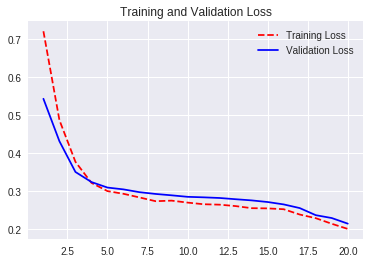

In [16]:
plt_loss(history)

# LSTM Based Baseline

In [17]:
# model pipline
model=Sequential()
model.add(layers.LSTM(32,input_shape=(None,dat.shape[-1])))
model.add(layers.Dense(24))

model.compile(optimizer=RMSprop(lr=1e-3),loss='mae')
history=model.fit_generator(train_gen,steps_per_epoch=200,epochs=20,validation_data=val_gen,validation_steps=val_step)

Epoch 1/20
200/200 [==============================] - 78s 390ms/step - loss: 0.7590 - val_loss: 0.5448
Epoch 2/20
200/200 [==============================] - 77s 384ms/step - loss: 0.4863 - val_loss: 0.4219
Epoch 3/20
170/200 [========================>.....] - ETA: 7s - loss: 0.3857

200/200 [==============================] - 76s 381ms/step - loss: 0.3813 - val_loss: 0.3616
Epoch 4/20
200/200 [==============================] - 77s 384ms/step - loss: 0.3227 - val_loss: 0.3072
Epoch 5/20
200/200 [==============================] - 77s 385ms/step - loss: 0.2820 - val_loss: 0.2767
Epoch 6/20
 24/200 [==>...........................] - ETA: 42s - loss: 0.2667

200/200 [==============================] - 77s 384ms/step - loss: 0.2550 - val_loss: 0.2552
Epoch 7/20
200/200 [==============================] - 77s 387ms/step - loss: 0.2315 - val_loss: 0.2355
Epoch 8/20
199/200 [============================>.] - ETA: 0s - loss: 0.2149

200/200 [==============================] - 77s 386ms/step - loss: 0.2150 - val_loss: 0.2193
Epoch 9/20
200/200 [==============================] - 77s 385ms/step - loss: 0.1996 - val_loss: 0.2111
Epoch 10/20
154/200 [======================>.......] - ETA: 10s - loss: 0.1912

200/200 [==============================] - 77s 384ms/step - loss: 0.1912 - val_loss: 0.2025
Epoch 11/20
200/200 [==============================] - 77s 385ms/step - loss: 0.1816 - val_loss: 0.1968
Epoch 12/20
200/200 [==============================] - 77s 385ms/step - loss: 0.1712 - val_loss: 0.1880
Epoch 13/20
 19/200 [=>............................] - ETA: 43s - loss: 0.1644

200/200 [==============================] - 77s 386ms/step - loss: 0.1620 - val_loss: 0.1837
Epoch 14/20
200/200 [==============================] - 77s 385ms/step - loss: 0.1544 - val_loss: 0.1773
Epoch 15/20
196/200 [============================>.] - ETA: 0s - loss: 0.1463

200/200 [==============================] - 77s 384ms/step - loss: 0.1462 - val_loss: 0.1665
Epoch 16/20
200/200 [==============================] - 77s 387ms/step - loss: 0.1406 - val_loss: 0.1625
Epoch 17/20
200/200 [==============================] - 77s 387ms/step - loss: 0.1351 - val_loss: 0.1647
Epoch 18/20
 27/200 [===>..........................] - ETA: 40s - loss: 0.1331

200/200 [==============================] - 77s 385ms/step - loss: 0.1315 - val_loss: 0.1571
Epoch 19/20
200/200 [==============================] - 77s 386ms/step - loss: 0.1299 - val_loss: 0.1574
Epoch 20/20
198/200 [============================>.] - ETA: 0s - loss: 0.1262

200/200 [==============================] - 77s 387ms/step - loss: 0.1261 - val_loss: 0.1606


In [0]:
with open('./drive/log_baseline_LSTM.txt','w') as f:
    f.write(str(history.history))

model.save('./drive/md_basline_LSTM.h5')

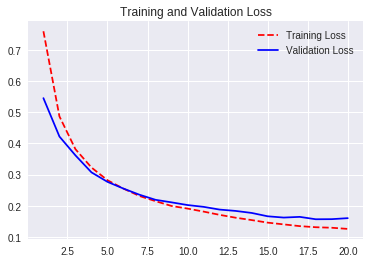

In [19]:
plt_loss(history)

# Dropout LSTM with Adaptive Learning Rate
It's trivial that LSTM shows better performance than GRU, so here I adopt dropout trick to make the model more robust. Besides, learning rate will be tuned adaptively and automatically by using call back module.

In [39]:
# model pipline
model=Sequential()
model.add(layers.LSTM(32,recurrent_dropout=.2,input_shape=(None,dat.shape[-1])))
model.add(layers.Dense(24))

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-5)  

model.compile(optimizer=RMSprop(lr=1e-3),loss='mae')
history=model.fit_generator(train_gen,steps_per_epoch=200,epochs=40,
                            callbacks=[reduce_lr],
                            validation_data=val_gen,validation_steps=val_step)



Epoch 1/40
200/200 [==============================] - 90s 450ms/step - loss: 0.7723 - val_loss: 0.5407
Epoch 2/40
200/200 [==============================] - 88s 441ms/step - loss: 0.4905 - val_loss: 0.4331
Epoch 3/40
170/200 [========================>.....] - ETA: 8s - loss: 0.3875

200/200 [==============================] - 88s 438ms/step - loss: 0.3817 - val_loss: 0.3419
Epoch 4/40
200/200 [==============================] - 89s 443ms/step - loss: 0.3086 - val_loss: 0.2802
Epoch 5/40
200/200 [==============================] - 89s 444ms/step - loss: 0.2642 - val_loss: 0.2513
Epoch 6/40
 24/200 [==>...........................] - ETA: 48s - loss: 0.2428

200/200 [==============================] - 88s 441ms/step - loss: 0.2369 - val_loss: 0.2307
Epoch 7/40
200/200 [==============================] - 88s 441ms/step - loss: 0.2172 - val_loss: 0.2180
Epoch 8/40
199/200 [============================>.] - ETA: 0s - loss: 0.2043

200/200 [==============================] - 89s 443ms/step - loss: 0.2042 - val_loss: 0.2121
Epoch 9/40
200/200 [==============================] - 89s 444ms/step - loss: 0.1948 - val_loss: 0.1986
Epoch 10/40
154/200 [======================>.......] - ETA: 12s - loss: 0.1838

200/200 [==============================] - 89s 444ms/step - loss: 0.1837 - val_loss: 0.1951
Epoch 11/40
200/200 [==============================] - 89s 443ms/step - loss: 0.1769 - val_loss: 0.1824
Epoch 12/40
200/200 [==============================] - 88s 441ms/step - loss: 0.1697 - val_loss: 0.1755
Epoch 13/40
 19/200 [=>............................] - ETA: 49s - loss: 0.1661

200/200 [==============================] - 89s 443ms/step - loss: 0.1649 - val_loss: 0.1709
Epoch 14/40
200/200 [==============================] - 89s 445ms/step - loss: 0.1603 - val_loss: 0.1691
Epoch 15/40
196/200 [============================>.] - ETA: 1s - loss: 0.1562

200/200 [==============================] - 88s 441ms/step - loss: 0.1563 - val_loss: 0.1656
Epoch 16/40
200/200 [==============================] - 89s 443ms/step - loss: 0.1516 - val_loss: 0.1586
Epoch 17/40
200/200 [==============================] - 88s 438ms/step - loss: 0.1478 - val_loss: 0.1618
Epoch 18/40
 27/200 [===>..........................] - ETA: 47s - loss: 0.1484

200/200 [==============================] - 89s 443ms/step - loss: 0.1465 - val_loss: 0.1555
Epoch 19/40
200/200 [==============================] - 89s 443ms/step - loss: 0.1441 - val_loss: 0.1550
Epoch 20/40
198/200 [============================>.] - ETA: 0s - loss: 0.1411

200/200 [==============================] - 89s 443ms/step - loss: 0.1410 - val_loss: 0.1496
Epoch 21/40
200/200 [==============================] - 89s 444ms/step - loss: 0.1388 - val_loss: 0.1482
Epoch 22/40
200/200 [==============================] - 89s 443ms/step - loss: 0.1367 - val_loss: 0.1487
Epoch 23/40
 27/200 [===>..........................] - ETA: 48s - loss: 0.1378

200/200 [==============================] - 88s 442ms/step - loss: 0.1363 - val_loss: 0.1521
Epoch 24/40
200/200 [==============================] - 89s 445ms/step - loss: 0.1352 - val_loss: 0.1598
Epoch 25/40
198/200 [============================>.] - ETA: 0s - loss: 0.1348

200/200 [==============================] - 88s 442ms/step - loss: 0.1347 - val_loss: 0.1433
Epoch 26/40
200/200 [==============================] - 88s 441ms/step - loss: 0.1325 - val_loss: 0.1468
Epoch 27/40
200/200 [==============================] - 87s 437ms/step - loss: 0.1314 - val_loss: 0.1449
Epoch 28/40
 27/200 [===>..........................] - ETA: 46s - loss: 0.1314

200/200 [==============================] - 88s 442ms/step - loss: 0.1300 - val_loss: 0.1459
Epoch 29/40
200/200 [==============================] - 88s 440ms/step - loss: 0.1297 - val_loss: 0.1419
Epoch 30/40
198/200 [============================>.] - ETA: 0s - loss: 0.1286

200/200 [==============================] - 87s 434ms/step - loss: 0.1286 - val_loss: 0.1442
Epoch 31/40
200/200 [==============================] - 88s 440ms/step - loss: 0.1276 - val_loss: 0.1422
Epoch 32/40
200/200 [==============================] - 88s 441ms/step - loss: 0.1270 - val_loss: 0.1439
Epoch 33/40
 27/200 [===>..........................] - ETA: 47s - loss: 0.1267

200/200 [==============================] - 88s 442ms/step - loss: 0.1260 - val_loss: 0.1464
Epoch 34/40
200/200 [==============================] - 88s 438ms/step - loss: 0.1251 - val_loss: 0.1459
Epoch 35/40
198/200 [============================>.] - ETA: 0s - loss: 0.1192

200/200 [==============================] - 88s 441ms/step - loss: 0.1193 - val_loss: 0.1364
Epoch 36/40
200/200 [==============================] - 88s 441ms/step - loss: 0.1183 - val_loss: 0.1360
Epoch 37/40
200/200 [==============================] - 88s 441ms/step - loss: 0.1185 - val_loss: 0.1366
Epoch 38/40
 27/200 [===>..........................] - ETA: 47s - loss: 0.1190

200/200 [==============================] - 88s 441ms/step - loss: 0.1182 - val_loss: 0.1357
Epoch 39/40
200/200 [==============================] - 88s 442ms/step - loss: 0.1178 - val_loss: 0.1360
Epoch 40/40
198/200 [============================>.] - ETA: 0s - loss: 0.1178

200/200 [==============================] - 88s 440ms/step - loss: 0.1178 - val_loss: 0.1358


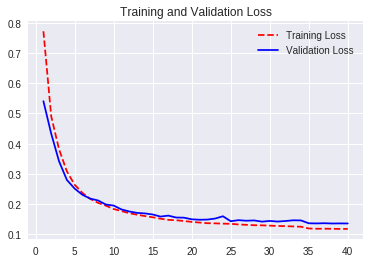

In [40]:
with open('./drive/log_dropout_LSTM.txt','w') as f:
    f.write(str(history.history))

model.save('./drive/md_dropout_LSTM.h5')

plt_loss(history)

# Dropout-Regularized, DNN-LSTM Model

In [14]:
md1=Sequential()
md1.add(layers.LSTM(32,recurrent_dropout=.2,
                   input_shape=(None,dat.shape[-1])))
md1.add(layers.Dense(32,activation='relu'))
md1.add(layers.BatchNormalization())
md1.add(layers.Dropout(.2))
md1.add(layers.Dense(32,activation='relu'))
md1.add(layers.Dropout(.2))
md1.add(layers.Dense(24))

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-5)  

md1.compile(optimizer=RMSprop(lr=1e-3),loss='mae')
hist=md1.fit_generator(train_gen,steps_per_epoch=200,epochs=40,
                            callbacks=[reduce_lr],
                            validation_data=val_gen,validation_steps=val_step)

Epoch 1/40
200/200 [==============================] - 88s 438ms/step - loss: 0.8846 - val_loss: 0.5350
Epoch 2/40
200/200 [==============================] - 87s 433ms/step - loss: 0.4889 - val_loss: 0.3664
Epoch 3/40
170/200 [========================>.....] - ETA: 8s - loss: 0.3529

200/200 [==============================] - 87s 434ms/step - loss: 0.3497 - val_loss: 0.2407
Epoch 4/40
200/200 [==============================] - 86s 432ms/step - loss: 0.3196 - val_loss: 0.2287
Epoch 5/40
200/200 [==============================] - 86s 432ms/step - loss: 0.3031 - val_loss: 0.2339
Epoch 6/40
 24/200 [==>...........................] - ETA: 47s - loss: 0.3056

200/200 [==============================] - 86s 429ms/step - loss: 0.2958 - val_loss: 0.2282
Epoch 7/40
200/200 [==============================] - 87s 437ms/step - loss: 0.2903 - val_loss: 0.2192
Epoch 8/40
199/200 [============================>.] - ETA: 0s - loss: 0.2812

200/200 [==============================] - 88s 438ms/step - loss: 0.2812 - val_loss: 0.2242
Epoch 9/40
200/200 [==============================] - 87s 436ms/step - loss: 0.2784 - val_loss: 0.2103
Epoch 10/40
154/200 [======================>.......] - ETA: 12s - loss: 0.2766

200/200 [==============================] - 85s 427ms/step - loss: 0.2756 - val_loss: 0.2194
Epoch 11/40
200/200 [==============================] - 85s 424ms/step - loss: 0.2714 - val_loss: 0.2176
Epoch 12/40
200/200 [==============================] - 84s 422ms/step - loss: 0.2675 - val_loss: 0.2022
Epoch 13/40
 19/200 [=>............................] - ETA: 48s - loss: 0.2626

200/200 [==============================] - 86s 431ms/step - loss: 0.2665 - val_loss: 0.2169
Epoch 14/40
200/200 [==============================] - 87s 435ms/step - loss: 0.2638 - val_loss: 0.1986
Epoch 15/40
196/200 [============================>.] - ETA: 1s - loss: 0.2623

200/200 [==============================] - 86s 429ms/step - loss: 0.2623 - val_loss: 0.1870
Epoch 16/40
200/200 [==============================] - 86s 428ms/step - loss: 0.2607 - val_loss: 0.1851
Epoch 17/40
200/200 [==============================] - 87s 437ms/step - loss: 0.2590 - val_loss: 0.1975
Epoch 18/40
 27/200 [===>..........................] - ETA: 47s - loss: 0.2580

200/200 [==============================] - 86s 432ms/step - loss: 0.2585 - val_loss: 0.2033
Epoch 19/40
200/200 [==============================] - 86s 431ms/step - loss: 0.2565 - val_loss: 0.1900
Epoch 20/40
198/200 [============================>.] - ETA: 0s - loss: 0.2545

200/200 [==============================] - 85s 427ms/step - loss: 0.2546 - val_loss: 0.1927
Epoch 21/40
200/200 [==============================] - 87s 436ms/step - loss: 0.2547 - val_loss: 0.2028
Epoch 22/40
200/200 [==============================] - 86s 429ms/step - loss: 0.2458 - val_loss: 0.1711
Epoch 23/40
 27/200 [===>..........................] - ETA: 46s - loss: 0.2435

200/200 [==============================] - 85s 426ms/step - loss: 0.2445 - val_loss: 0.1740
Epoch 24/40
200/200 [==============================] - 85s 427ms/step - loss: 0.2447 - val_loss: 0.1711
Epoch 25/40
198/200 [============================>.] - ETA: 0s - loss: 0.2434

200/200 [==============================] - 86s 428ms/step - loss: 0.2434 - val_loss: 0.1711
Epoch 26/40
200/200 [==============================] - 86s 428ms/step - loss: 0.2438 - val_loss: 0.1699
Epoch 27/40
200/200 [==============================] - 86s 428ms/step - loss: 0.2443 - val_loss: 0.1714
Epoch 28/40
 27/200 [===>..........................] - ETA: 46s - loss: 0.2423

200/200 [==============================] - 86s 429ms/step - loss: 0.2417 - val_loss: 0.1743
Epoch 29/40
200/200 [==============================] - 86s 429ms/step - loss: 0.2447 - val_loss: 0.1741
Epoch 30/40
198/200 [============================>.] - ETA: 0s - loss: 0.2436

200/200 [==============================] - 86s 428ms/step - loss: 0.2436 - val_loss: 0.1781
Epoch 31/40
200/200 [==============================] - 86s 428ms/step - loss: 0.2440 - val_loss: 0.1746
Epoch 32/40
200/200 [==============================] - 85s 427ms/step - loss: 0.2434 - val_loss: 0.1726
Epoch 33/40
 27/200 [===>..........................] - ETA: 46s - loss: 0.2434

200/200 [==============================] - 86s 428ms/step - loss: 0.2441 - val_loss: 0.1720
Epoch 34/40
200/200 [==============================] - 86s 428ms/step - loss: 0.2438 - val_loss: 0.1724
Epoch 35/40
198/200 [============================>.] - ETA: 0s - loss: 0.2435

200/200 [==============================] - 85s 427ms/step - loss: 0.2435 - val_loss: 0.1725
Epoch 36/40
200/200 [==============================] - 85s 425ms/step - loss: 0.2423 - val_loss: 0.1724
Epoch 37/40
200/200 [==============================] - 84s 422ms/step - loss: 0.2433 - val_loss: 0.1726
Epoch 38/40
 27/200 [===>..........................] - ETA: 45s - loss: 0.2403

200/200 [==============================] - 85s 425ms/step - loss: 0.2420 - val_loss: 0.1711
Epoch 39/40
200/200 [==============================] - 85s 425ms/step - loss: 0.2433 - val_loss: 0.1713
Epoch 40/40
198/200 [============================>.] - ETA: 0s - loss: 0.2435

200/200 [==============================] - 85s 425ms/step - loss: 0.2436 - val_loss: 0.1709


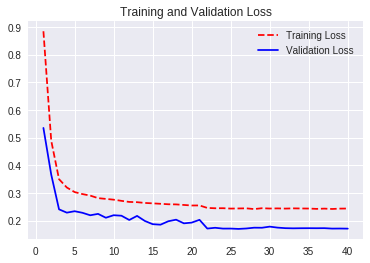

In [17]:
with open('./drive/log_DNN_LSTM.txt','w') as f:
    f.write(str(hist.history))
    
md1.save('./drive/DNN_LSTM.h5')

plt_loss(hist)

# DNN-LSTM-V2

In [0]:
main_input=Input(shape=(lookback//step,dat.shape[-1]))

x0 = LSTM(32,recurrent_dropout=.2)(main_input)
x = Dense(128, activation='relu', kernel_initializer='lecun_uniform',kernel_regularizer=regularizers.l2(regularizer))(x0)
x = BatchNormalization(beta_regularizer=regularizers.l2(regularizer),gamma_regularizer=regularizers.l2(regularizer))(x)
x = Dropout(.4)(x)
x = Concatenate()([x0, x])

x = Dense(64, activation='relu', kernel_initializer='lecun_uniform',kernel_regularizer=regularizers.l2(regularizer))(x)
x = BatchNormalization(beta_regularizer=regularizers.l2(regularizer),gamma_regularizer=regularizers.l2(regularizer))(x)
x = Dropout(.2)(x)
x = Concatenate()([x0, x])

x = Dense(32, activation='relu',kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(regularizer))(x)
x = BatchNormalization(beta_regularizer=regularizers.l2(regularizer),gamma_regularizer=regularizers.l2(regularizer))(x)
x = Dropout(.1)(x)

x = Dense(24, activation='linear',kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(regularizer))(x)

model =  Model(inputs=[main_input], outputs=[x])
model.compile(loss='mae', optimizer=Adam(lr=1e-3)) 

In [25]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, min_lr=1e-5)  
hist=model.fit_generator(train_gen,steps_per_epoch=200,epochs=50,
                            callbacks=[reduce_lr],
                            validation_data=val_gen,validation_steps=val_step)


Epoch 1/50
200/200 [==============================] - 33s 166ms/step - loss: 1.0838 - val_loss: 0.7334
Epoch 2/50
200/200 [==============================] - 32s 158ms/step - loss: 0.6227 - val_loss: 0.3953
Epoch 3/50
155/200 [======================>.......] - ETA: 4s - loss: 0.3652

200/200 [==============================] - 31s 157ms/step - loss: 0.3512 - val_loss: 0.2439
Epoch 4/50
200/200 [==============================] - 31s 157ms/step - loss: 0.2826 - val_loss: 0.2377
Epoch 5/50
200/200 [==============================] - 31s 157ms/step - loss: 0.2635 - val_loss: 0.2228
Epoch 6/50
 17/200 [=>............................] - ETA: 17s - loss: 0.2577

200/200 [==============================] - 31s 157ms/step - loss: 0.2489 - val_loss: 0.2216
Epoch 7/50
200/200 [==============================] - 31s 157ms/step - loss: 0.2406 - val_loss: 0.2053
Epoch 8/50
187/200 [===========================>..] - ETA: 1s - loss: 0.2310

200/200 [==============================] - 31s 157ms/step - loss: 0.2307 - val_loss: 0.1978
Epoch 9/50
200/200 [==============================] - 32s 158ms/step - loss: 0.2265 - val_loss: 0.1905
Epoch 10/50
200/200 [==============================] - 31s 157ms/step - loss: 0.2214 - val_loss: 0.1821
Epoch 11/50
 19/200 [=>............................] - ETA: 17s - loss: 0.2189

200/200 [==============================] - 31s 157ms/step - loss: 0.2180 - val_loss: 0.1784
Epoch 12/50
200/200 [==============================] - 31s 156ms/step - loss: 0.2139 - val_loss: 0.1761
Epoch 13/50
189/200 [===========================>..] - ETA: 1s - loss: 0.2106

200/200 [==============================] - 31s 156ms/step - loss: 0.2106 - val_loss: 0.1720
Epoch 14/50
200/200 [==============================] - 31s 156ms/step - loss: 0.2083 - val_loss: 0.1635
Epoch 15/50
200/200 [==============================] - 31s 157ms/step - loss: 0.2060 - val_loss: 0.1687
Epoch 16/50
 20/200 [==>...........................] - ETA: 17s - loss: 0.2039

200/200 [==============================] - 31s 157ms/step - loss: 0.2034 - val_loss: 0.1574
Epoch 17/50
200/200 [==============================] - 32s 158ms/step - loss: 0.2033 - val_loss: 0.1603
Epoch 18/50
185/200 [==========================>...] - ETA: 1s - loss: 0.1989

200/200 [==============================] - 31s 157ms/step - loss: 0.1989 - val_loss: 0.1578
Epoch 19/50
200/200 [==============================] - 32s 158ms/step - loss: 0.1972 - val_loss: 0.1586
Epoch 20/50
200/200 [==============================] - 32s 158ms/step - loss: 0.1962 - val_loss: 0.1575
Epoch 21/50
 10/200 [>.............................] - ETA: 18s - loss: 0.1993

200/200 [==============================] - 32s 158ms/step - loss: 0.1968 - val_loss: 0.1550
Epoch 22/50
200/200 [==============================] - 32s 158ms/step - loss: 0.1956 - val_loss: 0.1617
Epoch 23/50
183/200 [==========================>...] - ETA: 1s - loss: 0.1932

200/200 [==============================] - 32s 158ms/step - loss: 0.1935 - val_loss: 0.1490
Epoch 24/50
200/200 [==============================] - 32s 158ms/step - loss: 0.1937 - val_loss: 0.1518
Epoch 25/50
200/200 [==============================] - 31s 157ms/step - loss: 0.1917 - val_loss: 0.1538
Epoch 26/50
 22/200 [==>...........................] - ETA: 17s - loss: 0.1886

200/200 [==============================] - 31s 157ms/step - loss: 0.1895 - val_loss: 0.1503
Epoch 27/50
200/200 [==============================] - 31s 156ms/step - loss: 0.1906 - val_loss: 0.1518
Epoch 28/50
193/200 [===========================>..] - ETA: 0s - loss: 0.1888

200/200 [==============================] - 31s 156ms/step - loss: 0.1887 - val_loss: 0.1538
Epoch 29/50
200/200 [==============================] - 31s 157ms/step - loss: 0.1885 - val_loss: 0.1502
Epoch 30/50
200/200 [==============================] - 31s 156ms/step - loss: 0.1886 - val_loss: 0.1593
Epoch 31/50
 20/200 [==>...........................] - ETA: 17s - loss: 0.1866

200/200 [==============================] - 31s 156ms/step - loss: 0.1884 - val_loss: 0.1545
Epoch 32/50
200/200 [==============================] - 31s 156ms/step - loss: 0.1865 - val_loss: 0.1504
Epoch 33/50
192/200 [===========================>..] - ETA: 0s - loss: 0.1852

200/200 [==============================] - 31s 156ms/step - loss: 0.1855 - val_loss: 0.1973
Epoch 34/50
200/200 [==============================] - 31s 156ms/step - loss: 0.1919 - val_loss: 0.1518
Epoch 35/50
200/200 [==============================] - 31s 157ms/step - loss: 0.1848 - val_loss: 0.1483
Epoch 36/50
 24/200 [==>...........................] - ETA: 17s - loss: 0.1804

200/200 [==============================] - 31s 156ms/step - loss: 0.1842 - val_loss: 0.1443
Epoch 37/50
200/200 [==============================] - 31s 157ms/step - loss: 0.1840 - val_loss: 0.1424
Epoch 38/50
190/200 [===========================>..] - ETA: 0s - loss: 0.1853

200/200 [==============================] - 31s 157ms/step - loss: 0.1852 - val_loss: 0.1518
Epoch 39/50
200/200 [==============================] - 31s 157ms/step - loss: 0.1827 - val_loss: 0.1471
Epoch 40/50
200/200 [==============================] - 31s 157ms/step - loss: 0.1834 - val_loss: 0.1562
Epoch 41/50
 19/200 [=>............................] - ETA: 17s - loss: 0.1841

200/200 [==============================] - 31s 157ms/step - loss: 0.1836 - val_loss: 0.1483
Epoch 42/50
200/200 [==============================] - 31s 157ms/step - loss: 0.1823 - val_loss: 0.1501
Epoch 43/50
186/200 [==========================>...] - ETA: 1s - loss: 0.1837

200/200 [==============================] - 31s 157ms/step - loss: 0.1836 - val_loss: 0.1510
Epoch 44/50
200/200 [==============================] - 31s 157ms/step - loss: 0.1826 - val_loss: 0.1516
Epoch 45/50
200/200 [==============================] - 31s 157ms/step - loss: 0.1835 - val_loss: 0.1460
Epoch 46/50
 21/200 [==>...........................] - ETA: 17s - loss: 0.1830

200/200 [==============================] - 31s 157ms/step - loss: 0.1816 - val_loss: 0.1427
Epoch 47/50
200/200 [==============================] - 31s 157ms/step - loss: 0.1787 - val_loss: 0.1560
Epoch 48/50
187/200 [===========================>..] - ETA: 1s - loss: 0.1825

200/200 [==============================] - 31s 157ms/step - loss: 0.1823 - val_loss: 0.1460
Epoch 49/50
200/200 [==============================] - 31s 157ms/step - loss: 0.1831 - val_loss: 0.1392
Epoch 50/50
200/200 [==============================] - 31s 157ms/step - loss: 0.1799 - val_loss: 0.1381


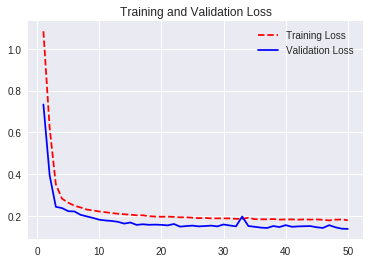

In [26]:
with open('./drive/log_DNN_LSTM_V2.txt','w') as f:
    f.write(str(hist.history))
    
model.save('./drive/DNN_LSTM_V2.h5')

plt_loss(hist)

## Fine Tuning

In [0]:
from keras.models import load_model  
  
model = load_model('./drive/DNN_LSTM_V2.h5')  

In [0]:
# fine tuning 1st
model.compile(loss='mae', optimizer=Adam(lr=1e-4)) 
hist=model.fit_generator(train_gen,steps_per_epoch=200,epochs=10,
                            validation_data=val_gen,validation_steps=val_step)

In [18]:
# fine tuning 2nd
model.compile(loss='mae', optimizer=Adam(lr=1e-5)) 
hist=model.fit_generator(train_gen,steps_per_epoch=200,epochs=10,
                            validation_data=val_gen,validation_steps=val_step)

Epoch 1/10
200/200 [==============================] - 34s 170ms/step - loss: 0.1757 - val_loss: 0.1380
Epoch 2/10
200/200 [==============================] - 33s 163ms/step - loss: 0.1770 - val_loss: 0.1356
Epoch 3/10
144/200 [====================>.........]

200/200 [==============================] - 33s 163ms/step - loss: 0.1770 - val_loss: 0.1356
Epoch 4/10
200/200 [==============================] - 33s 163ms/step - loss: 0.1767 - val_loss: 0.1346
Epoch 5/10
200/200 [==============================] - 32s 162ms/step - loss: 0.1756 - val_loss: 0.1372
Epoch 6/10
  2/200 [..............................] - ETA: 19s - loss: 0.1751

200/200 [==============================] - 32s 162ms/step - loss: 0.1753 - val_loss: 0.1386
Epoch 7/10
200/200 [==============================] - 32s 162ms/step - loss: 0.1755 - val_loss: 0.1354
Epoch 8/10
173/200 [========================>.....] - ETA: 2s - loss: 0.1759

200/200 [==============================] - 33s 163ms/step - loss: 0.1763 - val_loss: 0.1348
Epoch 9/10
200/200 [==============================] - 33s 163ms/step - loss: 0.1766 - val_loss: 0.1378
Epoch 10/10
200/200 [==============================] - 32s 162ms/step - loss: 0.1763 - val_loss: 0.1360


In [19]:
test_results=model.evaluate_generator(test_gen, steps=test_step)
print('The test error is:',test_results)

The test error is: 0.13915860652923584


In [0]:
model.save('./drive/DNN_LSTM_V2_ft.h5')